# Sentiment Analysis on Amazon Musical Instruments Dataset

**Acknowledgement**:

1) [N-Gram Analysis](https://www.kaggle.com/boldy717/textual-data-exploration-with-n-grams) - Brad Boldenow 

2) [Polarity](https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a)-Susan Li


In [45]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from itertools import cycle
import cufflinks as cf
from collections import Counter
from imblearn.over_sampling import SMOTE

In [46]:
#Importing Data set
raw_reviews = pd.read_csv('C:\\Projects\\Sentiment Analysis-Amazon Data\\data.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [47]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

In [48]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [49]:
process_reviews=process_reviews.dropna()

In [50]:
process_reviews.isnull().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [51]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

In [52]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5.0    6912
4.0    2079
3.0     771
2.0     249
1.0     216
Name: overall, dtype: int64

In [53]:
#Function to return sentiment value based on the overall ratings from the user 
def f(row):
    
   
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [54]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [55]:
process_reviews['sentiment'].value_counts() 

Positive    8991
Neutral      771
Negative     465
Name: sentiment, dtype: int64

In [56]:
month=process_reviews["reviewTime"].str.split(",").str.get(0).str.split(" ").str.get(0)
day=process_reviews["reviewTime"].str.split(",").str.get(0).str.split(" ").str.get(1)
year = process_reviews["reviewTime"].str.split(",").str.get(1)
process_reviews["day"]=day
process_reviews["month"]=month
process_reviews["year"]=year
process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment day month   year  
0  Positive  28    02   2014  
1  Positive  16    03   2013  
2  Positive  28    08   2013  
3  Positive  14    02   2014  
4  Positive  21    02   2014

In [57]:
process_reviews.helpful =process_reviews.helpful.str.replace(' ', '')
new1 = process_reviews["helpful"].str.split(",").str.get(0).str.split("[").str.get(1)
new2=process_reviews["helpful"].str.split(",").str.get(1).str.split("]").str.get(0)
#Converting into integer types
#new1=new1.astype(str).astype(int)
#new2=new2.astype(str).astype(int)
new1=new1.astype(int)
new2=new2.astype(int)
#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  new3= new1/new2
except ZeroDivisionError:
  new3=0

#Filling the NaN values(created due to dividing) with 0
new3 = new3.fillna(0)

#Rounding of the results to two decimal places
new3=new3.round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=new3

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)



In [58]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment day month  \
0  Not much to write about here, but it does exac...  Positive  28    02   
1  The product does exactly as it should and is q...  Positive  16    03   
2  The primary job of this device is to block the...  Positive  28    08   
3  Nice windscreen protects my MXL mic and preven...  Positive  14    02   
4  This pop filter is great. It looks and perform...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

In [59]:
process_reviews['helpful_rate'].value_counts()

0.00    7189
1.00    2037
0.50     266
0.67     136
0.75     111
        ... 
0.47       1
0.31       1
0.46       1
0.56       1
0.30       1
Name: helpful_rate, Length: 65, dtype: int64

In [60]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [61]:
#Function to make text lowercase,remove punctuation,remove words containing numbers and remove any all whitespace characters (space, tab, newline)
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=" ".join(text.split())
    return text

In [62]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much to write about here but it does exact...  Positive  28    02   
1  the product does exactly as it should and is q...  Positive  16    03   
2  the primary job of this device is to block the...  Positive  28    08   
3  nice windscreen protects my mxl mic and preven...  Positive  14    02   
4  this pop filter is great it looks and performs...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

In [63]:
#Creating stopwords because nltk stopwords removes certain words which indicate sentiment
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [64]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much write but exactly supposed filters po...  Positive  28    02   
1  product exactly quite affordablei not realized...  Positive  16    03   
2  primary job device block breath would otherwis...  Positive  28    08   
3  nice windscreen protects mxl mic prevents pops...  Positive  14    02   
4  pop filter great looks performs like studio fi...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

In [65]:
#Applying Stemming on the reviews column
ps = PorterStemmer()
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much write but exactli suppos filter pop s...  Positive  28    02   
1  product exactli quit affordablei not realiz do...  Positive  16    03   
2  primari job devic block breath would otherwis ...  Positive  28    08   
3  nice windscreen protect mxl mic prevent pop th...  Positive  14    02   
4  pop filter great look perform like studio filt...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

**Prior analysis assumptions:**

Higher the helpful rate the sentiment becomes positive
There will be more reviews at the starting of a month

In [66]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.308172
Neutral        0.276044
Positive       0.260641

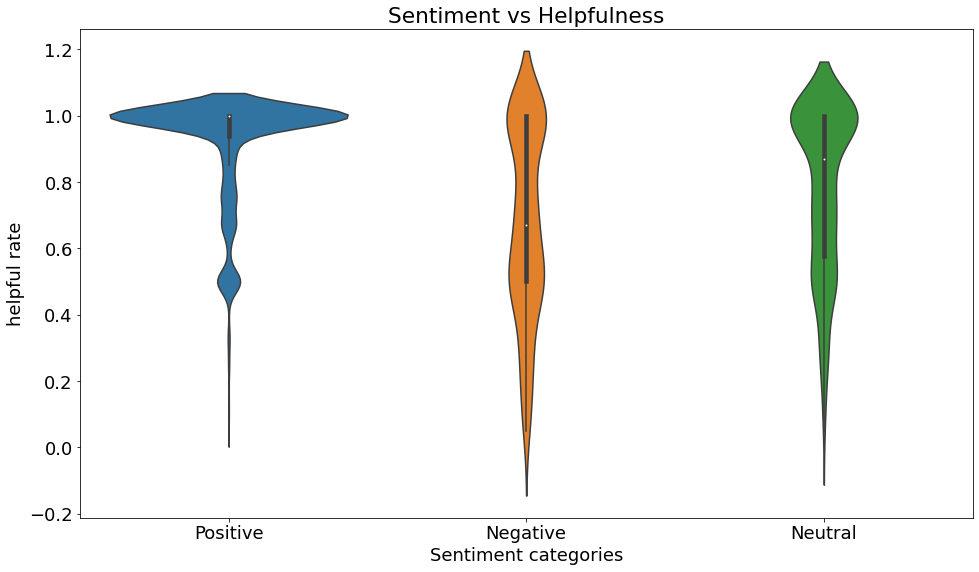

In [67]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

**From the plot we can declare that more number of positive reviews are having high helpful rate**

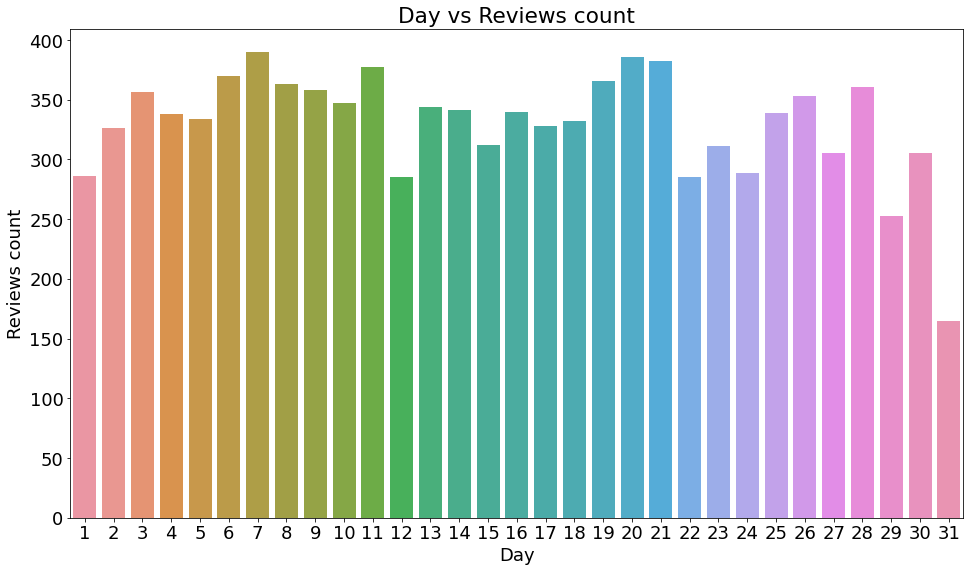

In [68]:
#Day of month vs Review
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month. 

In [69]:
#Creating new features
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [70]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much write but exactli suppos filter pop s...  Positive  28    02   
1  product exactli quit affordablei not realiz do...  Positive  16    03   
2  primari job devic block breath would otherwis ...  Positive  28    08   
3  nice windscreen protect mxl mic prevent pop th...  Positive  14    02   
4  pop filter great look perform like studio filt...  Positive  21    02   

    year  helpful_rate  polarity  review_len  word_count  
0   2014          0.00  0.183333         151          25  
1   2013          0.93  0.087500         316          55  
2   2013          1.00  0.186667         271          48  
3   2014          0.00  0.600000         147          22  
4   2014          0.00  0.800000         120          21

In [71]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

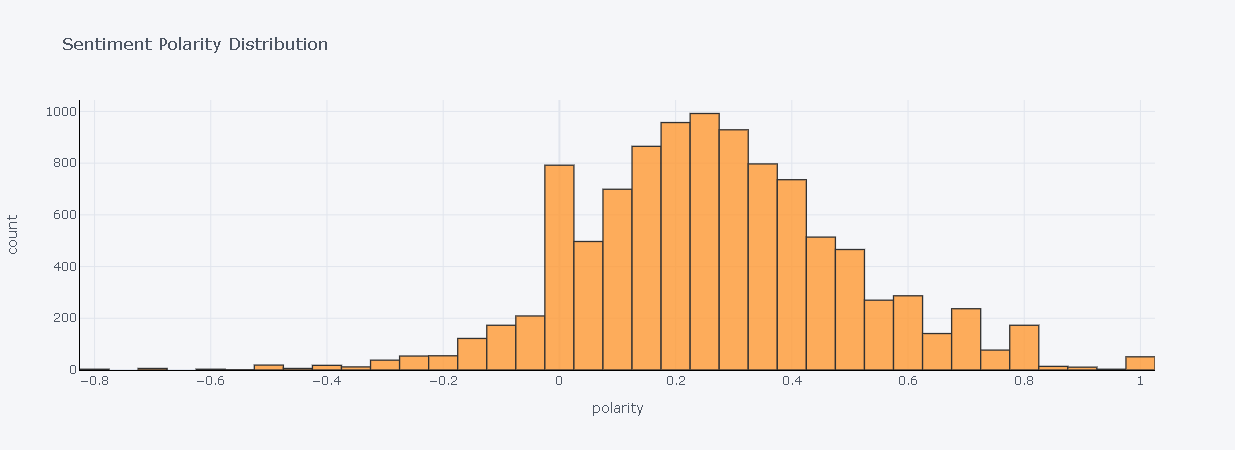

In [72]:
#Polarity distribution
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Insights:

We have a lot of positive polarities compared to the negative polarities
This polarity distributions assures the number of positive reviews we had
We can say that this polarity is a normally distributed but not standard normal

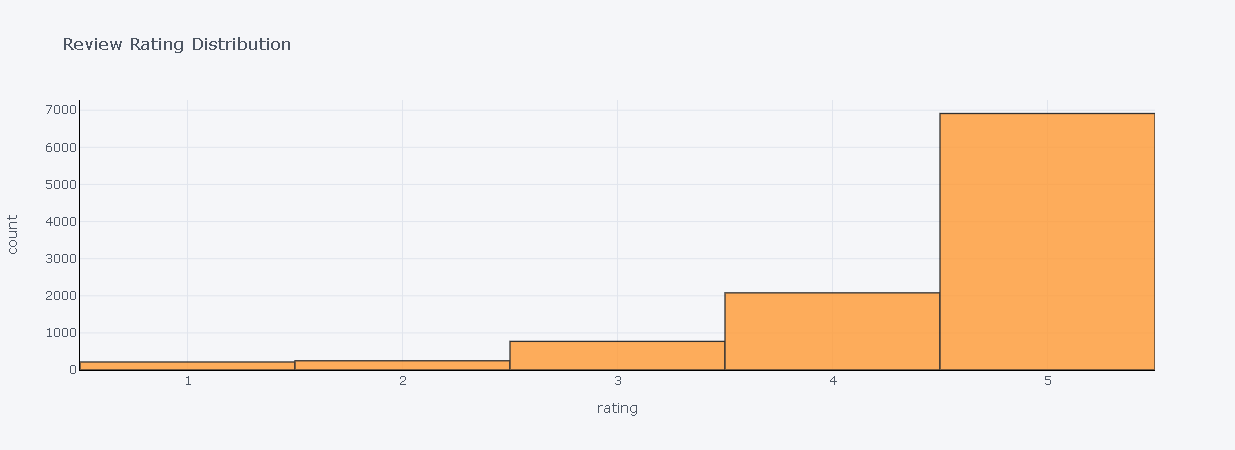

In [73]:
#Rating vs distribution
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. 

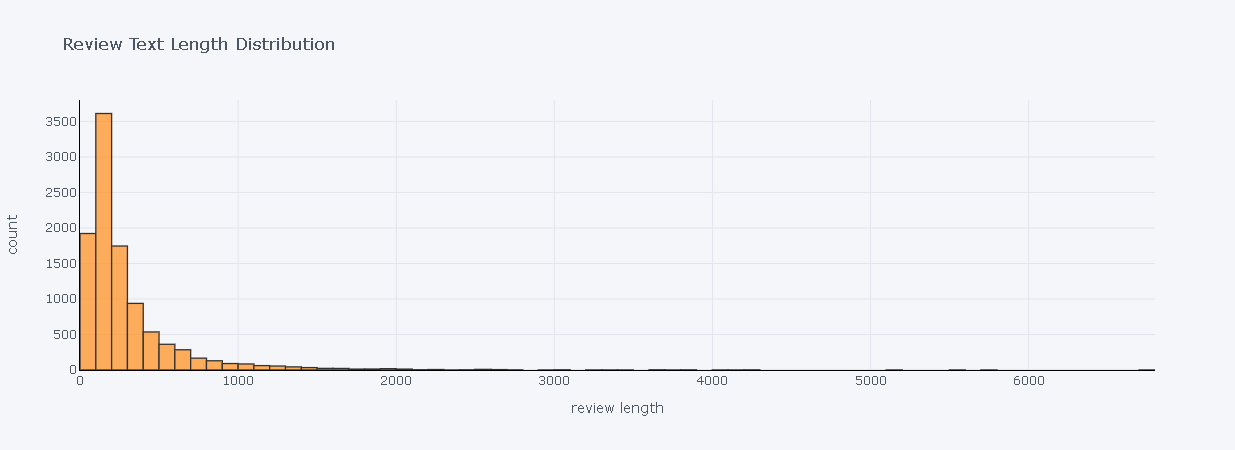

In [74]:
#Review Text distribution
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

We have a right skewed distribution with most of the words falling between 0-200 in a a review

****N-Gram Analysis****

The fuction documentNgrams computes n-grams of any size specified by the user. This function then packages the 15 most common n-grams into a pandas dataframe.

In [75]:
def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    df = df.head(15)
    df = df.sort_values(by='count')
    return(df)

Function plotNgrams, computes n-grams of size 1, 2, and 3. Using each of the n-gram dataframes, it then creates three horizontal bar charts for each n-gram size.

In [76]:

def plotNgrams(documents):
    unigrams = documentNgrams(documents, 1)
    bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (35, 10))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

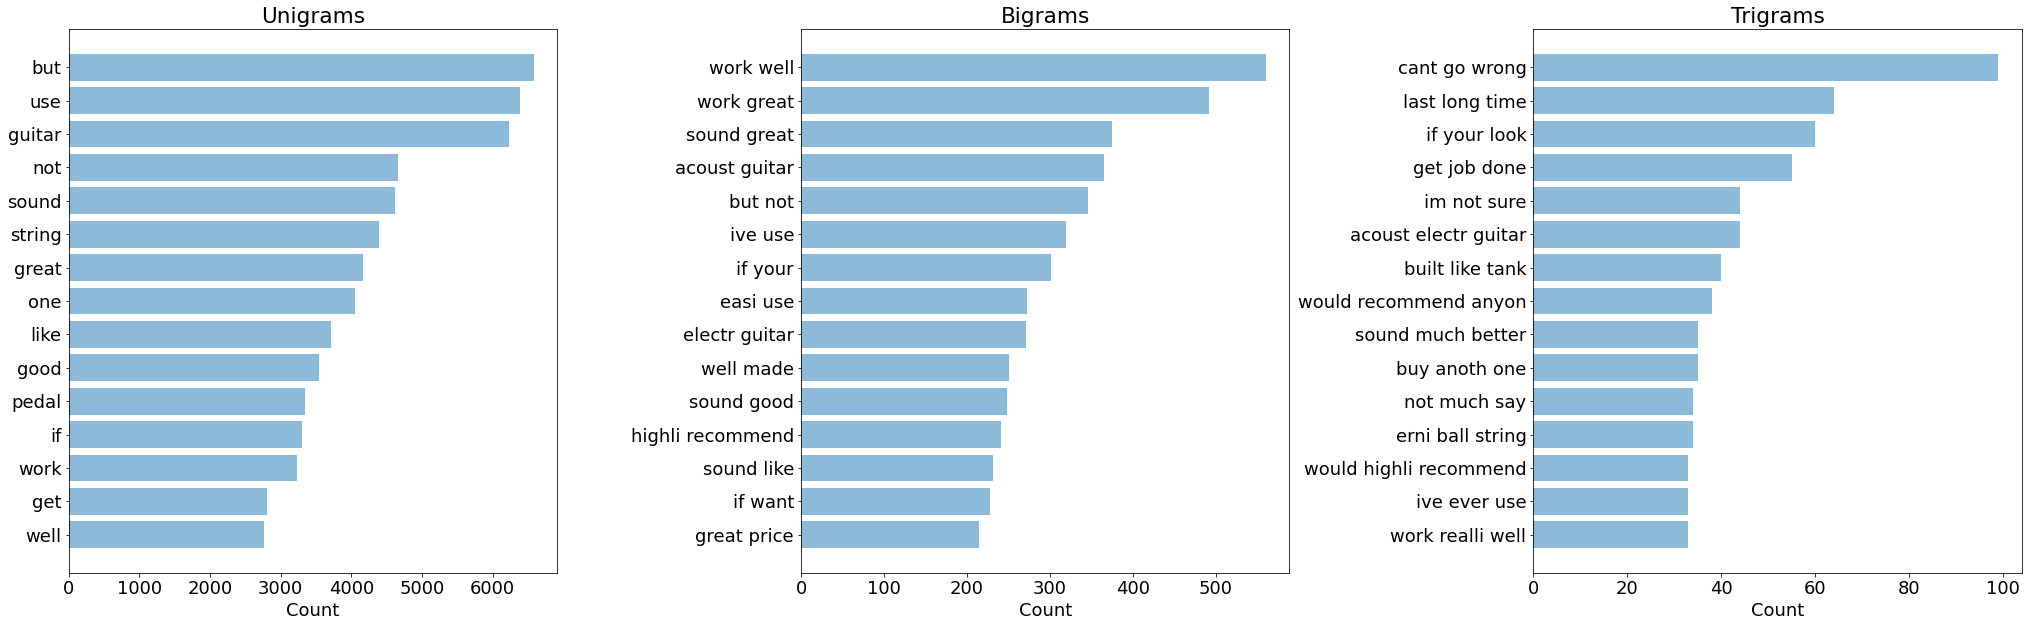

In [77]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()
plotNgrams(review_pos.reviews)

As we see, the words doen't match with the sentiment in montogram analysis. Bigram on the other hand give a much more clear idea about the sentiment amongst all the others. Hence we go forward with bigrams.

**Wordclouds**

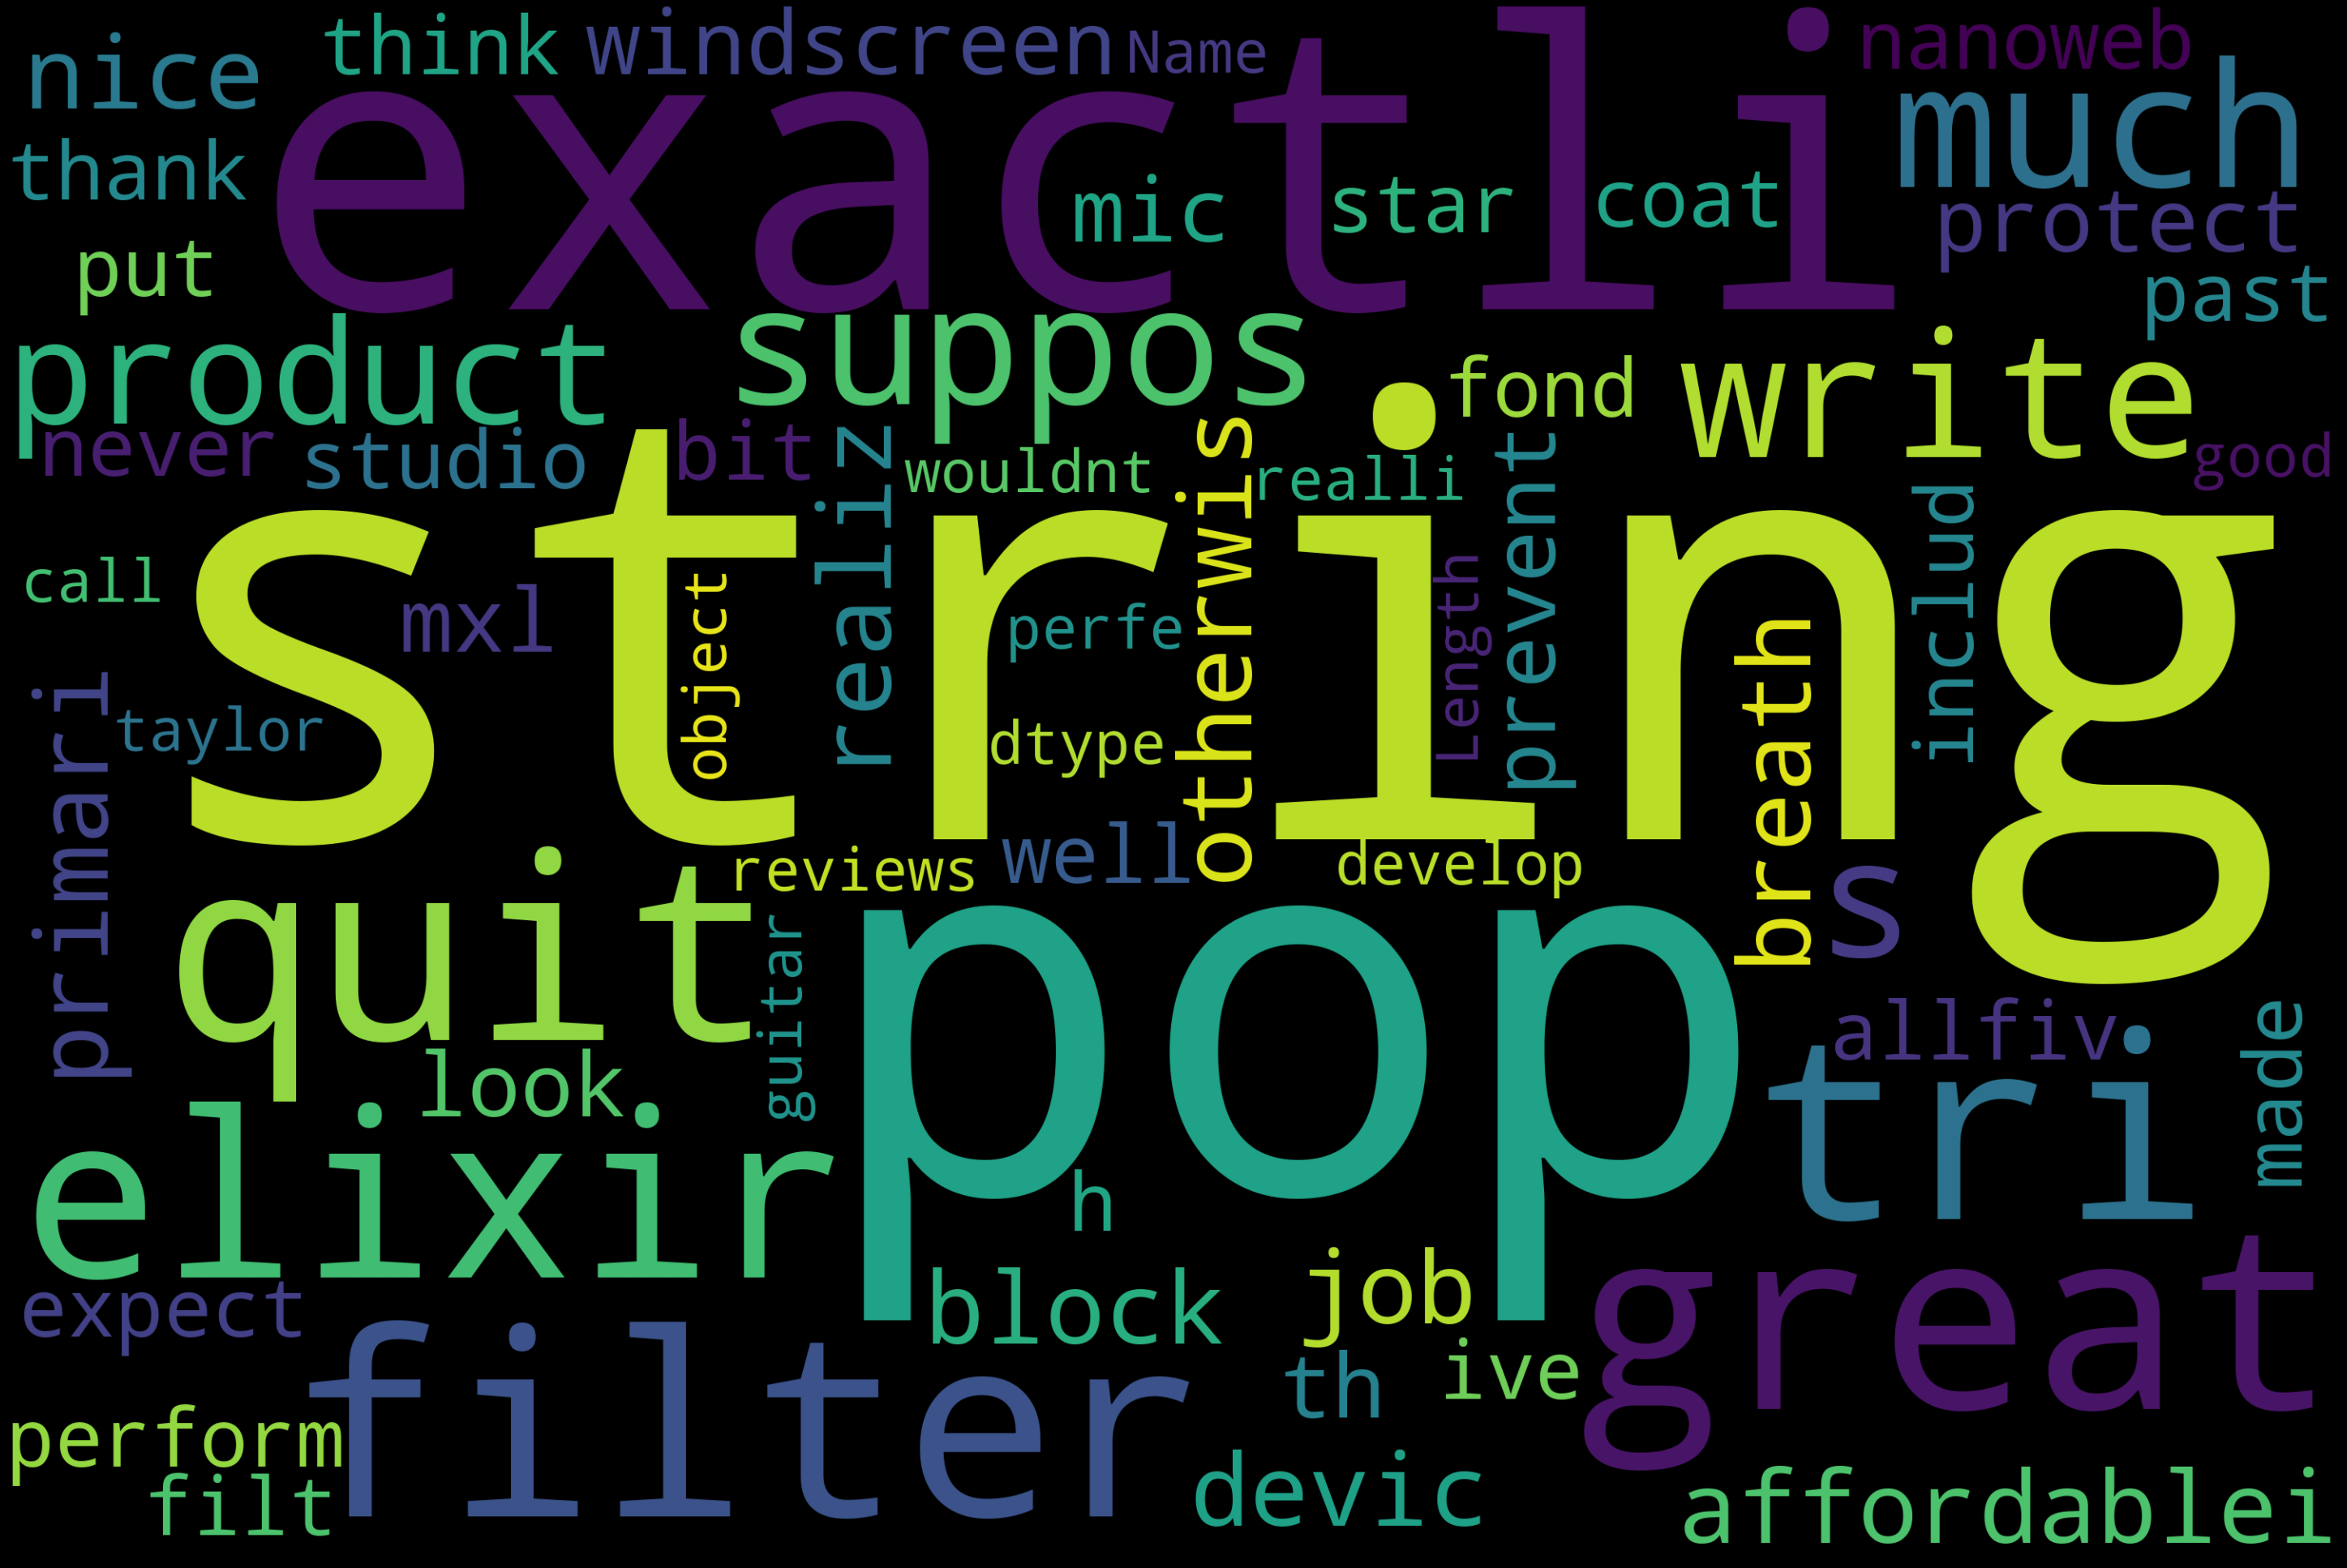

In [78]:
#For positive reviews
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can see positive words like great,affordable,expected,exactly etc

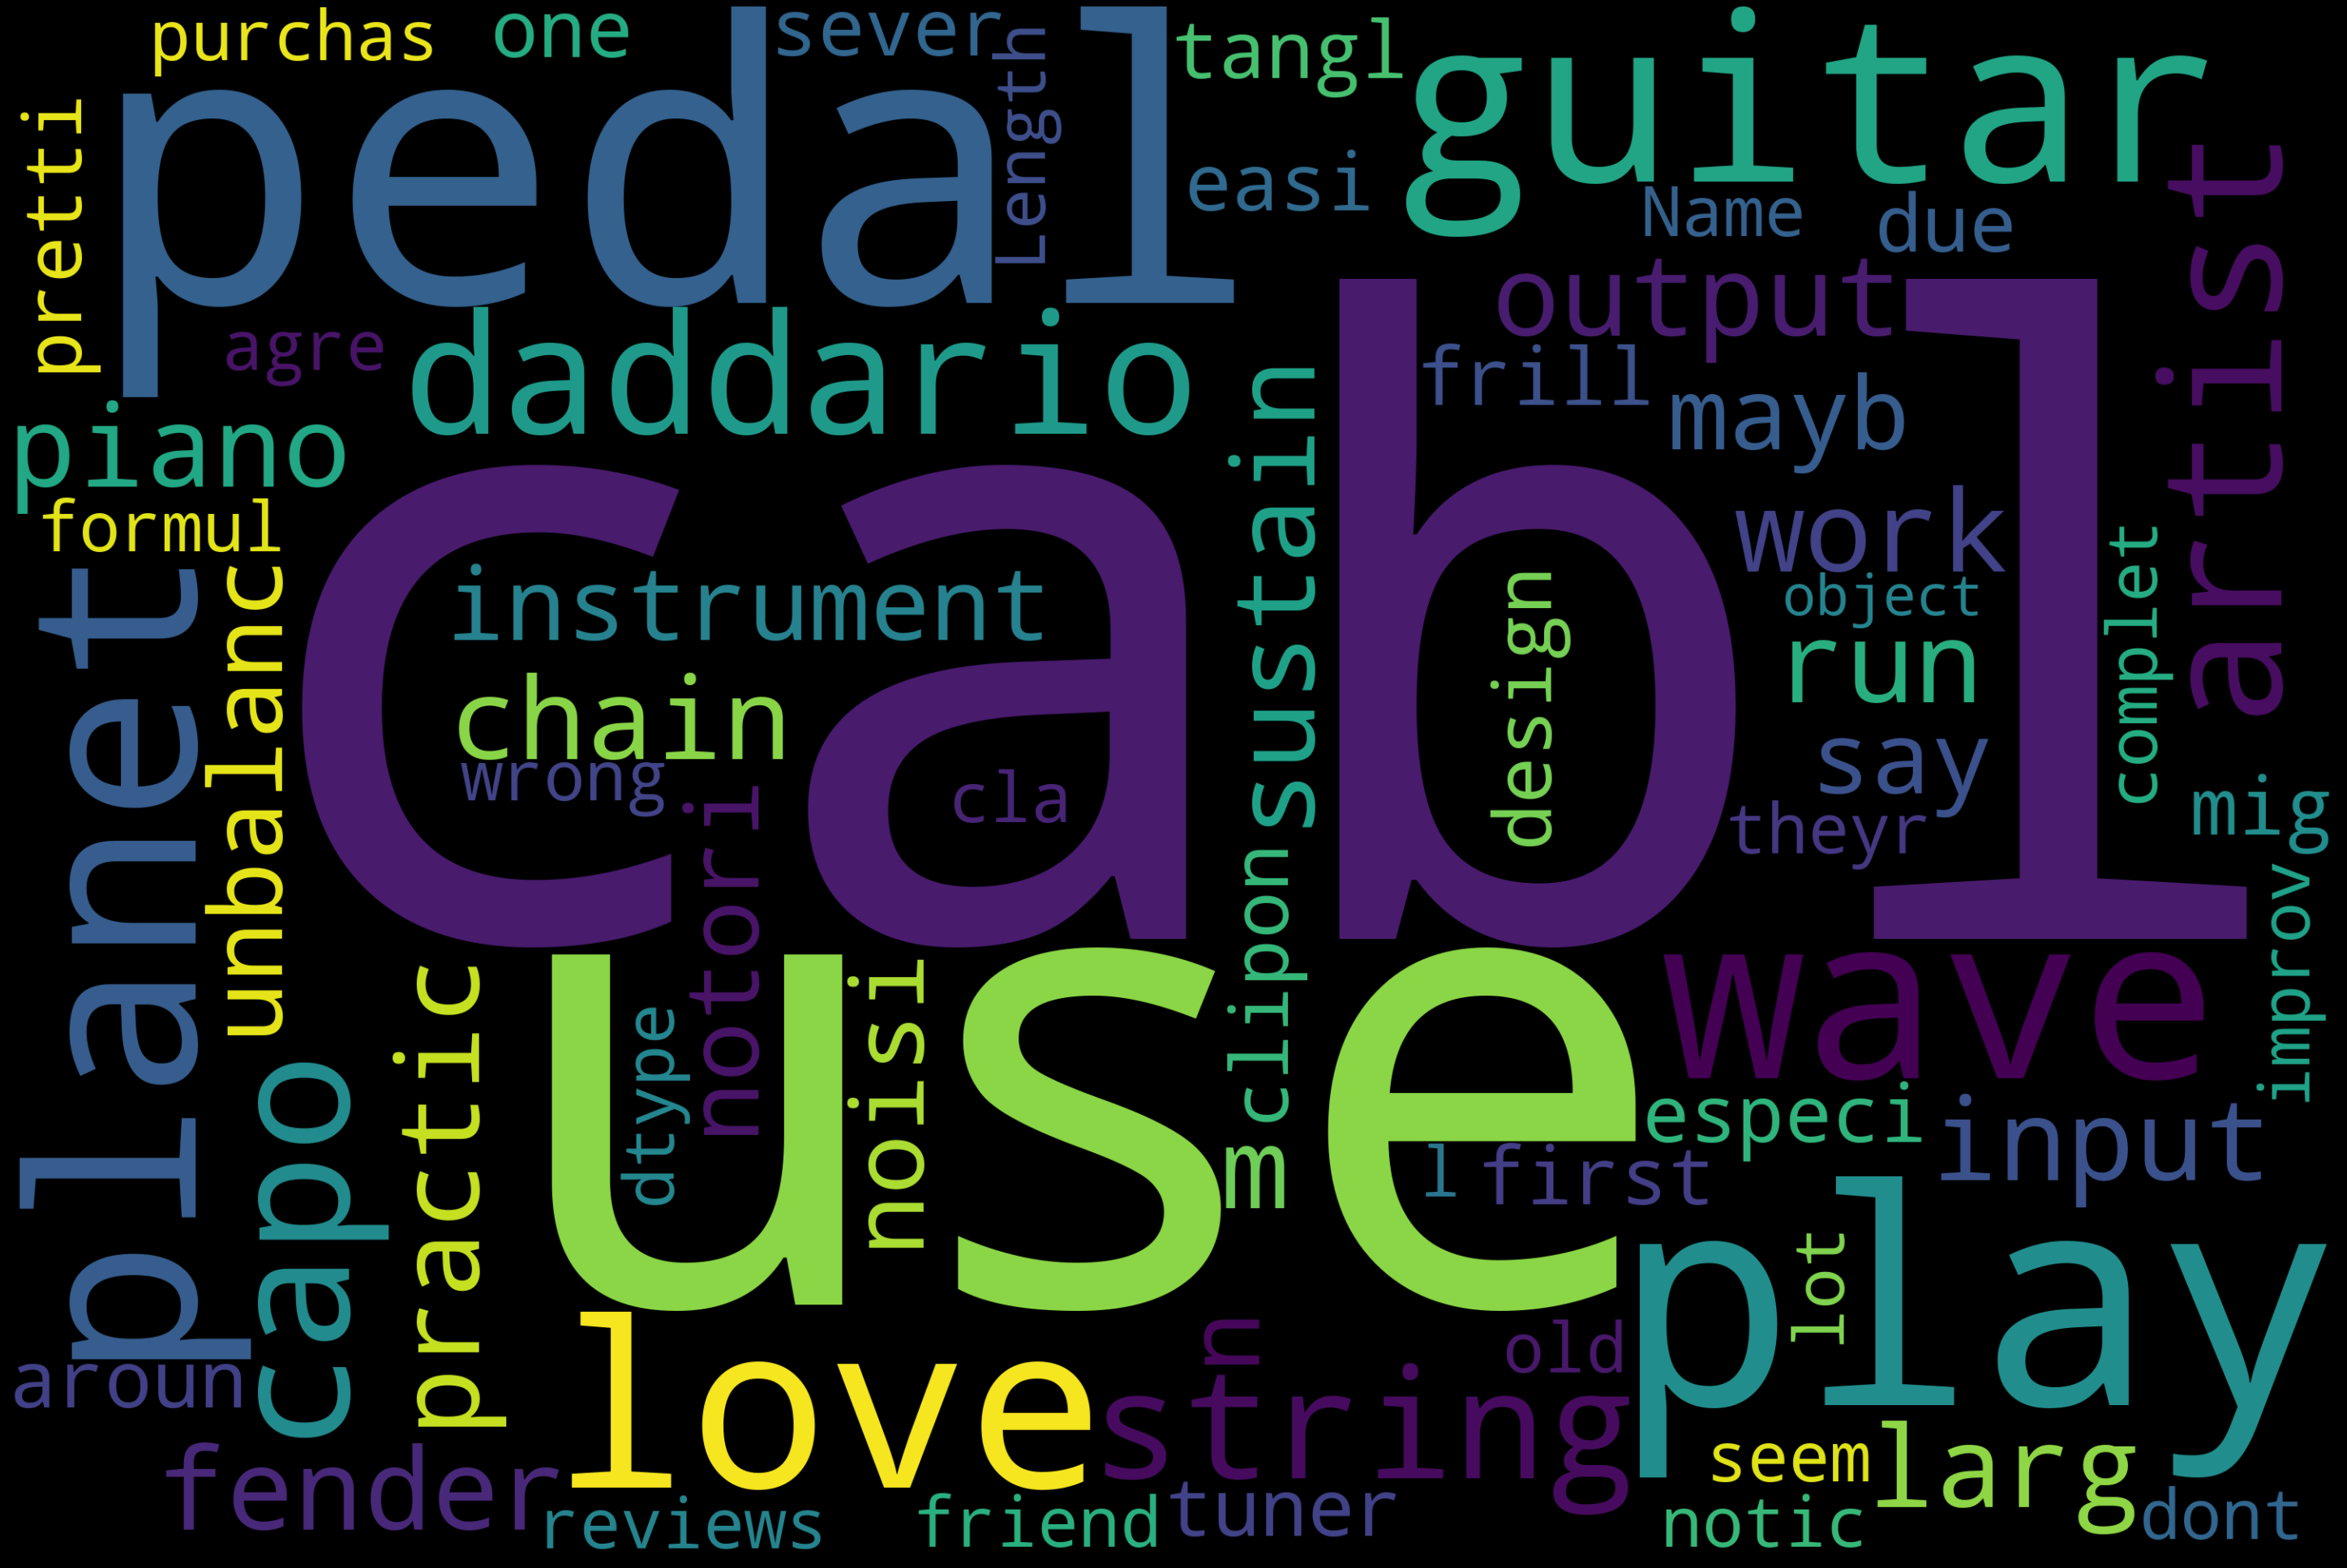

In [79]:
#For Neutral reviews
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Most of the neutral review words are focussed on the products and how can they be improved

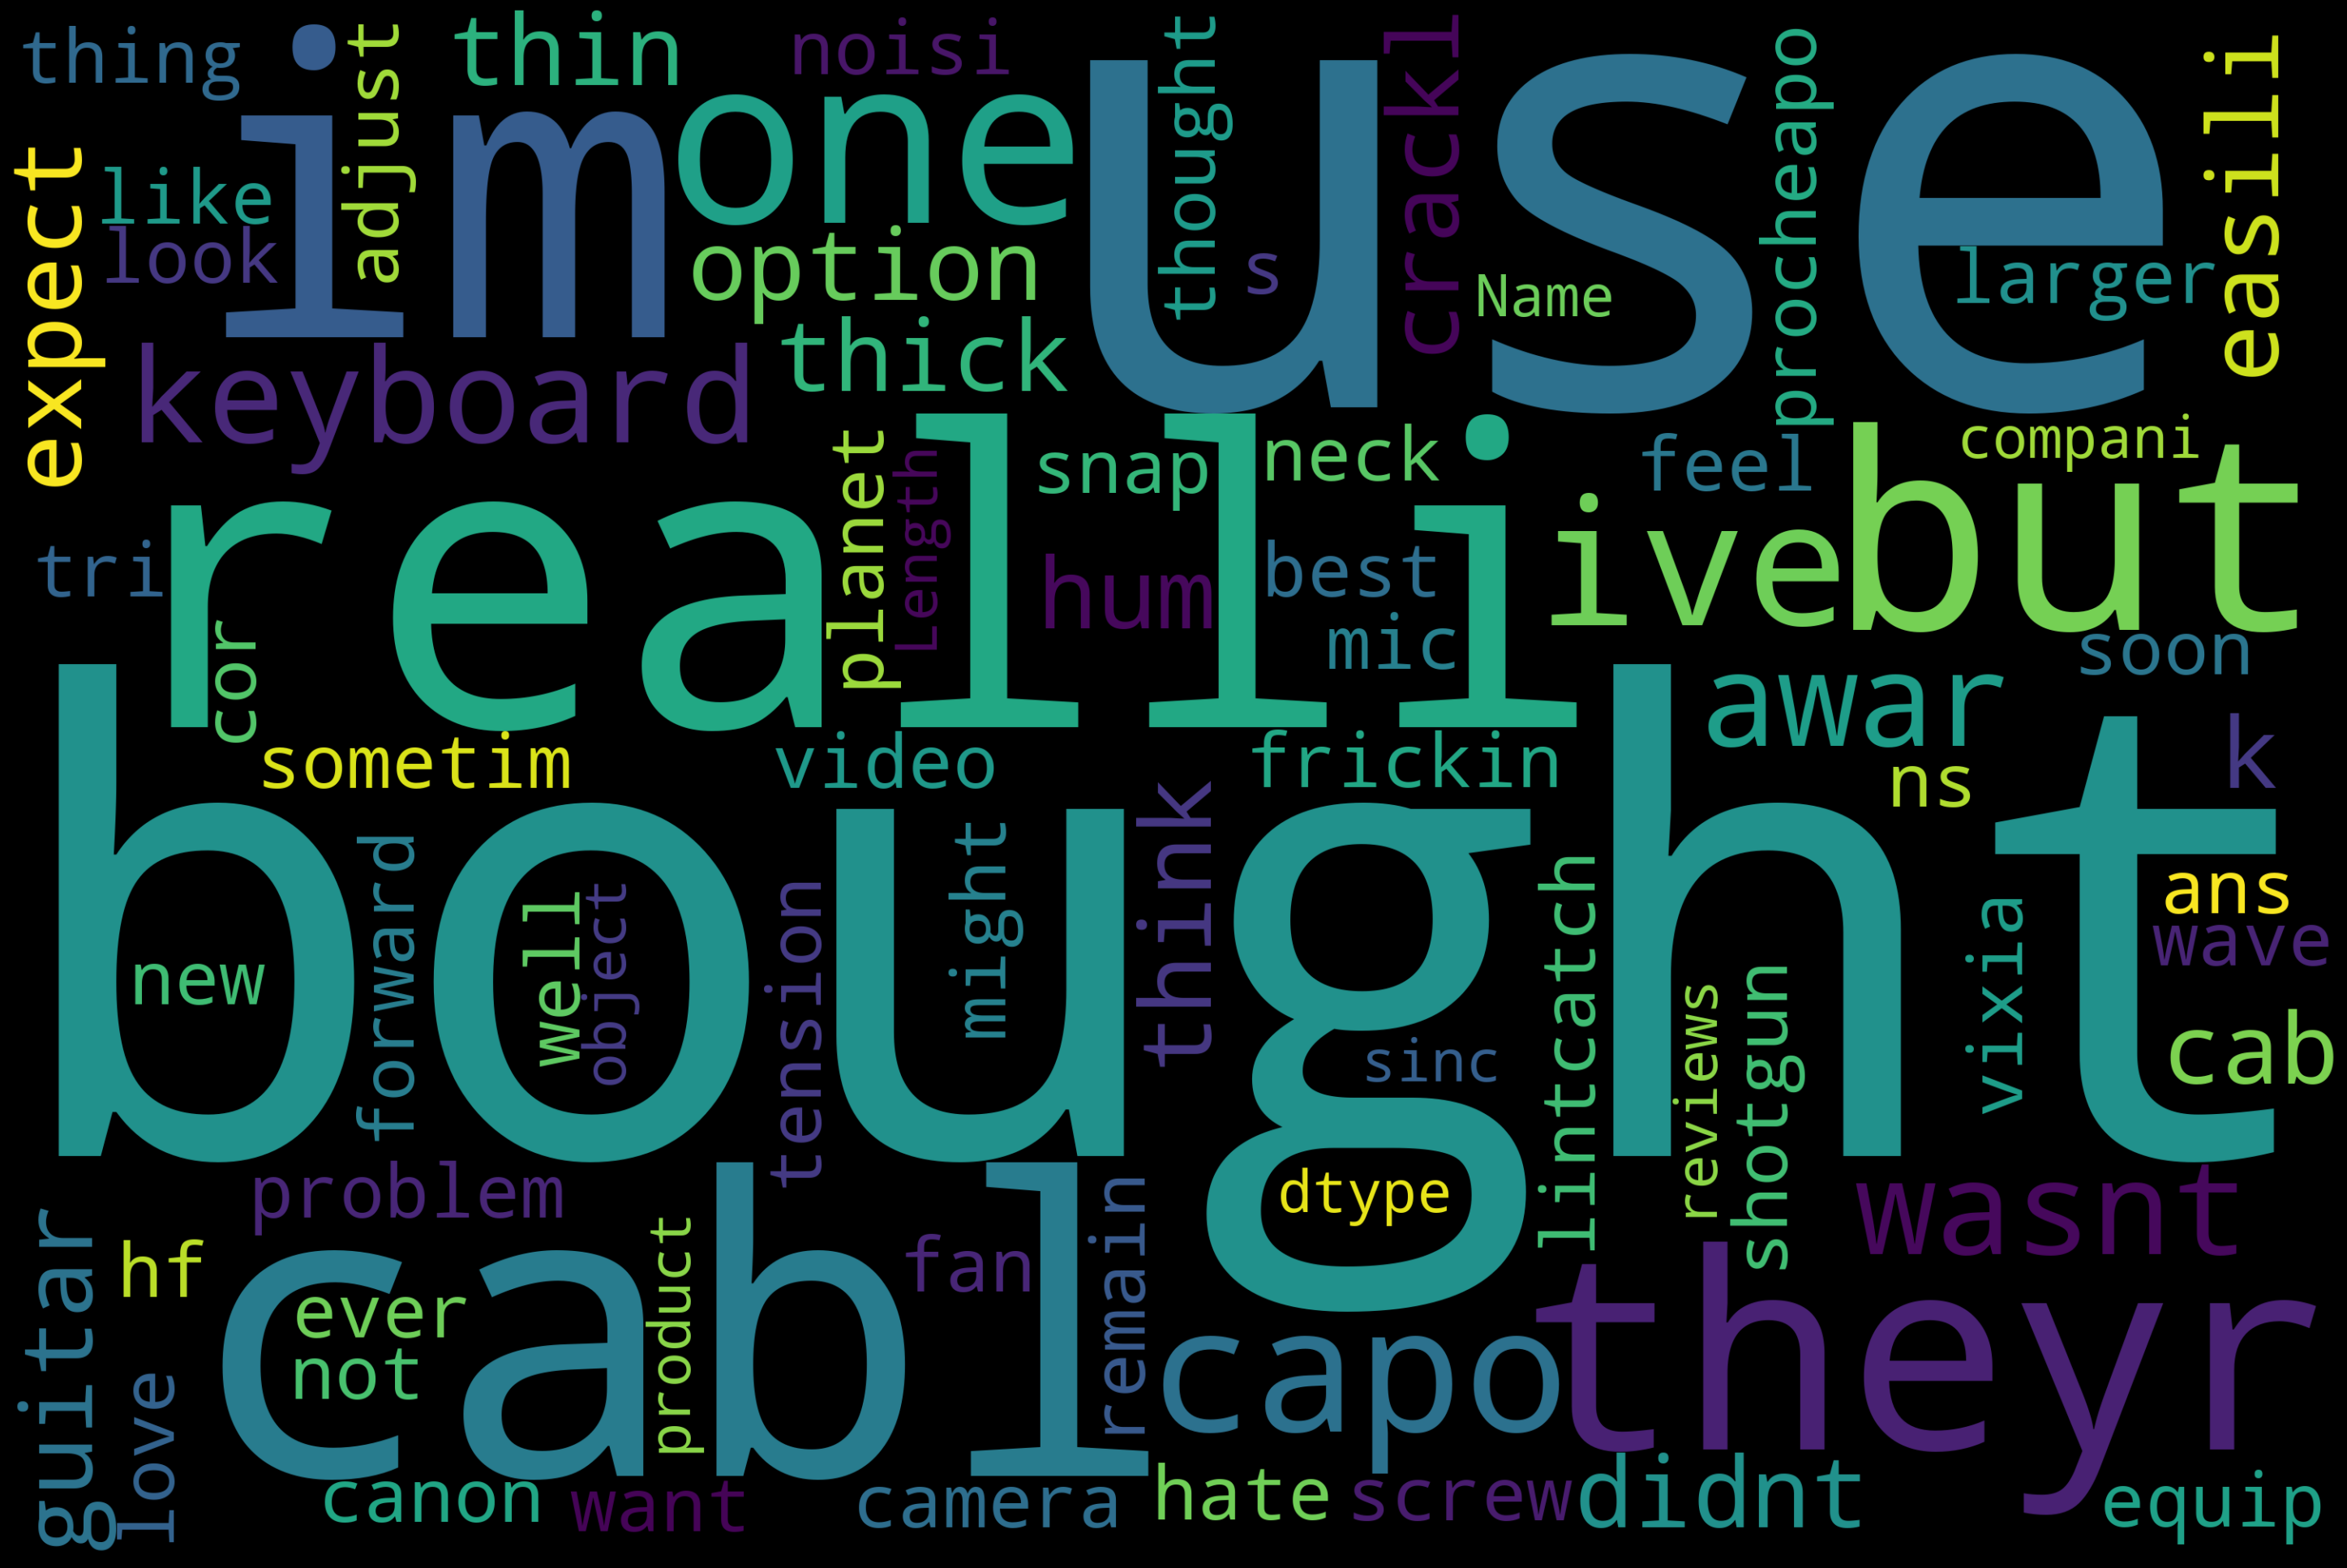

In [80]:
#Negative reviews
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can see negative review words such as noisy,didnt,frickin,wasnt,snap,problems,tension etc

**Extracting features and Vectorisation**

In [81]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique()

array([2, 1, 0])

In [82]:
process_reviews['sentiment'].value_counts()

2    8991
1     771
0     465
Name: sentiment, dtype: int64

In [83]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactli suppos filter pop s...
1  product exactli quit affordablei not realiz do...
2  primari job devic block breath would otherwis ...
3  nice windscreen protect mxl mic prevent pop th...
4  pop filter great look perform like studio filt...

In [84]:
#Tf-Idf vectorisation
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [85]:
X.shape

(10227, 5000)

In [86]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

**SMOTE TECHNIQUE FOR IMBALANCED DATASET PROBLEM**

In [87]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 8991, 1: 771, 0: 465})
Resampled dataset shape Counter({2: 8991, 1: 8991, 0: 8991})


**Train Test Split**

In [88]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [92]:
#Finding which model to use

logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8807082886181428
Decision Tree Test Accuracy: 0.8139242625102103
KNN Test Accuracy: 0.8691700478046037
SVC Test Accuracy: 0.8796324459161401
Naive Bayes Test Accuracy: 0.798857108424055


From the results, we can see logistic regression outdone the rest of the algorithms and all the accuracies from the results are more than 80%. That's great. So let's go with logistic regression with hyperparameter tuning.

**Logistic Regression with Hyperparameter tuning**

In [93]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9501779359430605


In [94]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [95]:
#Pinting confusion matrix
confusion_matrix(y_test,y_pred)

array([[2269,    0,    0],
       [  30, 2223,    0],
       [ 109,  197, 1916]])

In [96]:
#Getting the classification report
from sklearn.metrics import classification_report
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2269
           1       0.92      0.99      0.95      2253
           2       1.00      0.86      0.93      2222

    accuracy                           0.95      6744
   macro avg       0.95      0.95      0.95      6744
weighted avg       0.95      0.95      0.95      6744



As we have high f1-score of roughly 95 we have classified our data well!!!